# 09. Comparison of Model System Scales

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [5]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
using .Conversions
using .Diffusion

## 1. Revision of scale assumptions - 3 options

### 1.1. Spore-scale simulation

The diffusion model developed so far is based on the discretisation of space using a single spore diameter as a spatial increment. This leads to a straightforward abstraction of the spore as a special node on the lattice which differs in its concentration contribution from the nodes of the extracellular medium. However, it could be argued that this discretisation is too arbitrary, too rough or leading to incoherences in the interpretation of the interface between spore and medium. For this reason, two additional alternative schemes are proposed.

### 1.2. Super-spore-scale simulation

First, inspired by the approach taken in the derivation of the analytical scheme in Notebook 7, it can be assumed that the spore source is of negligible size compared to the lattice resolution and that a single lattice site is a discrete box that _contains_ the spore, but their boundaries are not coincident. The spore can therefore be seen as a singular source which is not significantly large to pose an obstacle for diffusion within the box, but adds new concentration to the box with a rate based on the concentration difference between the spore and the medium. In this sense, the slow-permeating sub-system of the spore is spatially removed from the sub-system of the medium lattice, but they do communicate via the entry node assumed to contain the spore. The concentration drop between the spore and its containing cell evolves over time as follows:

$$
\begin{equation}
\frac{d{(c_{\textrm{in}}-c_{\textrm{out}})}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}})
\end{equation}
$$

This can be rewritten as

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}-\frac{d{c_{\textrm{out}}}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}}).
\end{equation}
$$

The derivative $\frac{d{c_{\textrm{out}}}}{dt}$ is approximated by a finite difference scheme:

$$
\begin{equation}
\frac{d{c_{\textrm{out}}}}{dt}\approx\frac{c_{\textrm{out}}(t+\delta{t})-c_{\textrm{out}}(t)}{\delta{t}}
\end{equation}
$$

Similarly,

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}\approx\frac{c_{\textrm{in}}(t+\delta{t})-c_{\textrm{in}}(t)}{\delta{t}}
\end{equation}
$$

Using these discretisations, the update of the spore concentration can be expressed as

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+c_{\textrm{in}}(t)-c_{\textrm{out}}(t)-\frac{AP_s}{V}\delta{t}(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))=c_{\textrm{out}}(t+\delta{t})+(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{V}\delta{t}\right).
\end{equation}
$$

The problem arising here is the interdependence between $c_{\textrm{in}}(t+\delta{t})$ and $c_{\textrm{out}}(t+\delta{t})$. This can be resolved by implementing a half-step for updating the concentration drop:

$$
\begin{equation}
\Delta{c}^{(1/2)}=(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

The outside concentration in the spore-containing volume is then updated as a mixture of free diffusion with neighbour cells of the medium and the added concentration from the source:

$$
\begin{equation}
c_{\textrm{out}}(t+\delta{t})=c_{\textrm{out}}(t)+\delta{t}\left[D\nabla^2c_{\textrm{out}}(t)+\frac{AP_s}{V}\Delta{c}^{(1/2)}\right].
\end{equation}
$$

Finally, the inside concentration at a full time step can be completed:

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+\Delta{c}^{(1/2)}\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

### 1.3. Cell-wall-scale simulation

A second option considers the opposite scenario --- a much more fine-grain lattice, such that the detail of the spore's spherical shape can be captured. This becomes important in observing the spatial articulation of spore packings caused by aggregation and furthermore improves the accuracy of the diffusion simulation by considering scales closer to the infinitessimal limit.

Since the high resolution of the lattice requires significantly increased computation, drastic optimisation measures are required. For this purpose, each cell in the lattice performs a dynamic check of its distance to the spore centre, given the spore radius. If the cell falls within this radius but has excluded neighbours (in its von Neumann neighbourhood), then it is considered a member of the cell wall - the source region governed by slow diffusion. If it is excluded from the radius along with all of its neighbours, it is a member of the medium region. If the cell and all of its neighbours are within the radius, it is excluded from the computation.

## 2. Comparative experiment

The two newly proposed options are constructed and tested against the original discretisation scheme, applying different resolutions on a lattice with the same spatial dimensions and simulating inhibitor diffusion with a single spore. The concentration at the spore is recorded and compared to the analytical solution and among the numerical schemes.

In [34]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 10#4400 # s
c0 = 1.018 # M
spore_diameter = 5 # microns
K = 316.23 # partition coefficient

# ----- Analytical solution -----
c_out = 0.0 # M
times = LinRange(0, t_max, 1000)

# Cube spore
V_spore_cube = spore_diameter^3 # microns^3
A_spore_cube = 6 * spore_diameter^2 # microns^2
c_analytical_cube = permeation_time_dependent_analytical(c0, c_out, times, Ps_fit, A_spore_cube, V_spore_cube)
println("Analytical solution for spore with V=$V_spore_cube and A=$A_spore_cube: ", c_analytical_cube[end])

# Sphere spore
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
c_analytical_sphere = permeation_time_dependent_analytical(c0, c_out, times, Ps_fit, A_spore_sphere, V_spore_sphere)
println("Analytical solution for spore with V=$V_spore_sphere and A=$A_spore_sphere: ", c_analytical_sphere[end])

# ----- Numerical solution -----
n_save_frames = 100

# Mid resolution
# N_mid = 64
# dt = 0.005
# spore_idx = (N_mid ÷ 2, N_mid ÷ 2, N_mid ÷ 2)
# c_init = zeros(N_mid, N_mid, N_mid)
# c_init[spore_idx...] = c0
# c_numerical, times_numerical, _ = diffusion_time_dependent_GPU(c_init, t_max; D, Ps=Ps_fit, dt=dt, dx=spore_diameter, n_save_frames=n_save_frames, spore_idx=spore_idx)
# println("Numerical solution (mid-resolution): ", c_numerical[end, spore_idx...])

# # Low resolution
# scale_factor = 4 # 1 cell is 4 spore diameters long
# N_lo = N_mid ÷ scale_factor
# dt = 0.1
# dx = spore_diameter * scale_factor
# spore_vol_idx = (N_lo ÷ 2, N_lo ÷ 2, N_lo ÷ 2)
# c_init = zeros(N_lo, N_lo, N_lo)
# _, c_numerical, times_numerical, _ = diffusion_time_dependent_GPU_low_res(c_init, c0, t_max; D=D, Pₛ=Ps_fit, 
#                                                                             A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
#                                                                             n_save_frames=n_save_frames, spore_vol_idx=spore_vol_idx)
# println("Numerical solution (low-resolution): ", c_numerical[end])

# High resolution
N_hi = 64#256#1600 # 1 cell is 0.20 um long
dt = 0.00001#0.00001
dx = 0.2 # cell wall thickness
Db = Ps_fit * dx #/ K # compute diffusion coefficient from permeability
spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
c_init = zeros(Float64, N_hi, N_hi, N_hi)
c_numerical, times_numerical, _ = diffusion_time_dependent_GPU_hi_res(c_init, c0, [spore_center_idx], spore_diameter / 2, 1.0;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames)
# println("Numerical solution (low-resolution): ", c_numerical[end])

Analytical solution for spore with V=125 and A=150: 1.0147370292521385
Analytical solution for spore with V=65.44984694978736 and A=78.53981633974483: 1.0147370292521385
Using D = 600, Db = 5.350706139023637e-5, Deff = 0.00010701411323712153
Spore radius in lattice units: 12.5
Concentrations initialised.
Storage arrays allocated.
Kernel blocks: (8, 8, 8), kernel threads: (8, 8, 8)
0.0
1.2266761013961514e-5
2.3774377041263506e-5
3.5281886594020764e-5
4.678924060135614e-5
5.829636499402113e-5
6.980288942577318e-5
8.130913980130572e-5
9.281539017683827e-5
0.00010432164055237081
0.0001158278835209785
0.00012733411908266135
0.00013884036205126903
0.00015034661983372643
0.00016185286280233414
0.00017335909095709214
0.00018486533392569982
0.00019637156208045781
0.0002078778050490655
0.0002193840628315229
0.00023089026135858149
0.0002423965191410389
0.00025390188809251414
0.0002654056423343718
0.00027690939657622947
0.0002884131804457866
0.0002999169643153437
0.0003114207481849007
0.0003229245

([0.0 0.0 … 0.0 0.0; 7.841356907078989e-8 7.883681261944275e-8 … 8.010477833408913e-8 7.883681261944275e-8; … ; 3.084048335585976e-5 3.084119256891427e-5 … 3.084331650461536e-5 3.084119256891427e-5; 3.118612380058039e-5 3.118683486536611e-5 … 3.118896065279841e-5 3.118683486536611e-5;;; 0.0 0.0 … 0.0 0.0; 7.883681261944275e-8 7.926335456431843e-8 … 8.054124440093347e-8 7.926335456431843e-8; … ; 3.084119256891427e-5 3.08419054854312e-5 … 3.0844040531519565e-5 3.08419054854312e-5; 3.118683486536611e-5 3.1187549633614255e-5 … 3.118968282797141e-5 3.1187549633614255e-5;;; 0.0 0.0 … 0.0 0.0; 8.010477833408913e-8 8.054124440093347e-8 … 8.184892107010455e-8 8.054124440093347e-8; … ; 3.084331650461536e-5 3.0844040531519565e-5 … 3.0846205205307346e-5 3.0844040531519565e-5; 3.118896065279841e-5 3.118968282797141e-5 … 3.11918493534904e-5 3.118968282797141e-5;;; … ;;; 0.0 0.0 … 0.0 0.0; 8.221213525416715e-8 8.266516563537607e-8 … 8.402257864759122e-8 8.266516563537607e-8; … ; 3.084684220084455e-5 

Nonzero elements: 399200


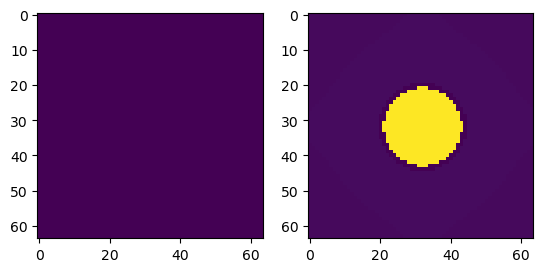

In [ ]:
# Count nonzero
println("Nonzero elements: ", count(!iszero, c_numerical))

fig, ax = subplots()
ax.imshow(c_numerical[1, :, :], cmap="viridis")
ax.set_xlim(100, 155)
ax.set_ylim(100, 155)
# ax.set_xlim(750, 850)
# ax.set_ylim(750, 850)
gcf()

fig, axs = subplots(1, 2)
axs[1].imshow(c_numerical[1, :, :], cmap="viridis")
axs[1].set_xlim(114, 155)
axs[1].set_ylim(100, 155)
axs[2].imshow(c_numerical[end, :, :], cmap="viridis")
axs[2].set_xlim(114, 155)
axs[2].set_ylim(100, 155)
gcf()

In [ ]:
using Pkg
Pkg.add("IterTools")

   Resolving package versions...
    Updating `C:\Users\mihbo\.julia\environments\v1.10\Project.toml`
  [c8e1da08] + IterTools v1.10.0
  No Changes to `C:\Users\mihbo\.julia\environments\v1.10\Manifest.toml`
┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
│   SparseArraysExt [85068d23-b5fb-53f1-8204-05c2aba6942f]
│   AtomixCUDAExt [13011619-4c7c-5ef0-948f-5fc81565cd05]
│   CUDAExt [11b7e2e0-d079-575b-885e-0ab22ef3252c]
│   LinearAlgebraExt [66d79d19-2cc4-5b0b-ac7a-b340256d1ecd]
│   ChainRulesCoreExt [eae2faf6-b232-58cb-a410-7764fda2830c]
└ @ Pkg.API C:\Users\mihbo\.julia\juliaup\julia-1.10.5+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\API.jl:1279


## 3. Sparse matrix exercise

In [ ]:
using SparseArrays
using IterTools

In [ ]:
N = 20
rad = 5
spore_idx = (N ÷ 2, N ÷ 2)
medium_is, medium_js, medium_cs = [], [], []
cw_is, cw_js, cw_concs = [], [], []
for i in 1:N
    for j in 1:N
        steps = [-1, 0, 1]
        von_neumann_nbrs = collect(IterTools.product(steps, steps))
        excluded = false
        excluded_nbrs = 0
        for (di, dj) in von_neumann_nbrs
            if (i + di - spore_idx[1])^2 + (j + dj - spore_idx[2])^2 > rad^2
                if (di, dj) == (0, 0)
                    excluded = true
                    push!(medium_is, i)
                    push!(medium_js, j)
                    push!(medium_cs, 1.0)
                else
                    excluded_nbrs += 1
                end
            end
        end
        if !excluded && excluded_nbrs > 0
            push!(cw_is, i)
            push!(cw_js, j)
            push!(cw_concs, 1.0)
        end
    end
end
# nz_is = hcat(nz_is...)
# nx_js = hcat(nx_js...)
# nz_concs = hcat(nz_concs...)
medium_sparse = sparse(medium_is, medium_js, medium_cs, N, N)
cw_sparse = sparse(cw_is, cw_js, cw_concs, N, N)

20×20 SparseMatrixCSC{Any, Int64} with 36 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⢠⠖⠚⠒⢦⠀⠀⠀⎥
⎢⠀⠀⢺⠀⠀⠀⢸⠂⠀⠀⎥
⎢⠀⠀⠈⠓⠲⠒⠋⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦